In [20]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

%matplotlib notebook

!pip install nltk

import nltk


In [2]:

df = pd.read_csv("amazon_baby.csv")
df.head()



,name,review,rating
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5


<IPython.core.display.Javascript object>


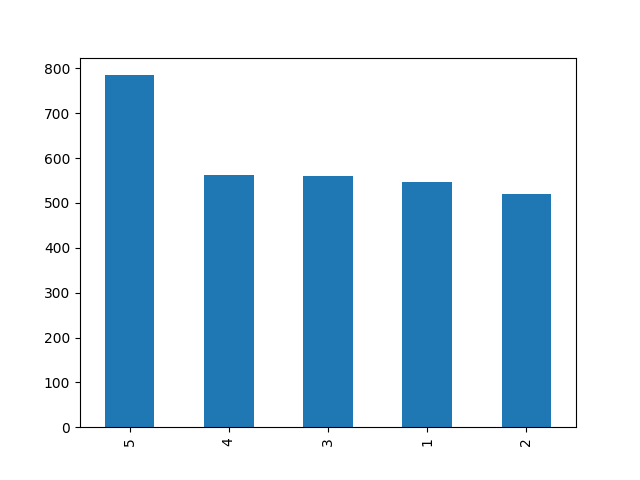

In [3]:

df.name.value_counts()[:20].plot(kind="bar")

Analyze top product reviews


In [5]:
top_product = df[df.name == "Vulli Sophie the Giraffe Teether"]

<IPython.core.display.Javascript object>


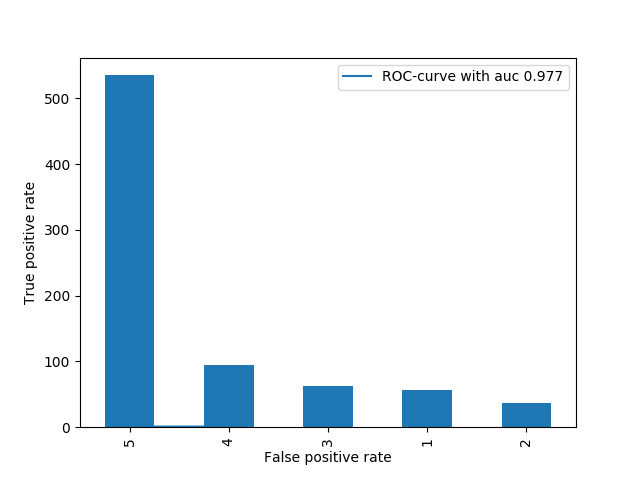

In [7]:
top_product.rating.value_counts().plot(kind="bar")

### Build the word count vector for each review

For word counting I'll use sklearn CountVectorizer


In [38]:
s = df.review.values[0]
from nltk.tokenize import RegexpTokenizer
from collections import defaultdict
def count_words(s):
    d = defaultdict(int)
    for w in RegexpTokenizer("\w+").tokenize(s):
        d[w.lower()] += 1
    return dict(d)

count_words(s)


{'12': 1,
 '6': 1,
 '8': 1,
 'a': 2,
 'about': 1,
 'also': 1,
 'and': 5,
 'are': 3,
 'because': 1,
 'been': 1,
 'blue': 1,
 'boyfor': 1,
 'but': 1,
 'cloth': 2,
 'countwhich': 1,
 'fab': 1,
 'faces': 1,
 'flannel': 1,
 'for': 2,
 'get': 1,
 'had': 2,
 'handles': 1,
 'hands': 1,
 'have': 2,
 'higher': 1,
 'i': 2,
 'in': 1,
 'issues': 1,
 'just': 1,
 'keeping': 1,
 'larger': 1,
 'longer': 1,
 'months': 1,
 'my': 1,
 'need': 1,
 'nicer': 1,
 'no': 1,
 'not': 1,
 'now': 1,
 'ocean': 1,
 'ok': 1,
 'opinion': 1,
 'ordered': 1,
 'pack': 1,
 'quality': 1,
 'replace': 1,
 'rough': 1,
 'seemed': 1,
 'softer': 1,
 'someimse': 1,
 'starting': 1,
 'stink': 1,
 'stripping': 1,
 'texture': 1,
 'that': 1,
 'them': 1,
 'these': 1,
 'they': 1,
 'to': 2,
 'use': 1,
 'usingthirsties': 1,
 'vimse': 1,
 'while': 1,
 'wipes': 4,
 'worth': 1}

In [40]:
df["words"] = df.review.apply(count_words)


In [44]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

#transform dataframe. Set target to 1 if rating is 4, 5; 0 for 1, 2 and drop 3 reviews.

transformed_df = df[df.rating != 3]
transformed_df["target"] = (transformed_df.rating >= 4).astype(int)

#Build pipeline: 
# pipeline is set of feature extractors, processors and classifier.
# pipeline can be trained with GridSearch, which will find best coefficients for each pipeline item.
pipeline = Pipeline([
    #It will encode dict features
    ("vec", DictVectorizer()),
    #I use logistic regression
    ("clf", LogisticRegression())
])

# With different param grids I found out that best params are: max_df~0.8, min_df~0.1
param_grid = dict(

)

gs = GridSearchCV(pipeline, param_grid, n_jobs=8, cv=2)

train, test = train_test_split(transformed_df.dropna(), train_size=.8, random_state=0)

gs.fit(train.words, train.target)


/home/stas/envs/ml/lib/python2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


GridSearchCV(cv=2, error_score='raise',
       estimator=Pipeline(steps=[('vec', DictVectorizer(dtype=<type 'numpy.float64'>, separator='=', sort=True,
        sparse=True)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=8, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [46]:
print "Best Score", gs.best_score_
print "Best Params", gs.best_params_



Best Score 0.929238058592
Best Params {}


<IPython.core.display.Javascript object>


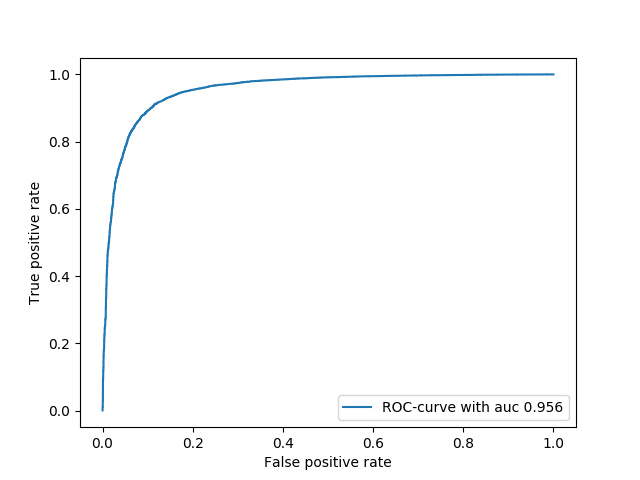

In [49]:
#calculate ROC on test data

clf = gs.best_estimator_

from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(test.target, clf.predict_proba(test.words)[:, 1], pos_label=1)

plt.plot(fpr, tpr)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(["ROC-curve with auc {0:.3f}".format(metrics.auc(fpr, tpr))])



In [50]:
y_real, y_pr = test.target, clf.predict(test.words)
cm =metrics.confusion_matrix(y_real, y_pr, labels=[1, 0])

print "True positive: {}\t False positive: {}\nFalse negative: {}\tTrue negative: {}".format(
    *cm.ravel()
)
print "Accuracy: {}\t Precision: {}".format(metrics.accuracy_score(y_real, y_pr), 
                                            metrics.precision_score(y_real, y_pr))


True positive: 27018	 False positive: 896
False negative: 1323	True negative: 3899
Accuracy: 0.933033558667	 Precision: 0.953318513814


In [81]:
metrics.accuracy_score?

### Find most positive and negative reviews

In [51]:
df = df.dropna()
df["prediction"] = clf.predict_proba(df.words)[:, 1]

In [54]:
df["target"] = (df.rating >= 4).astype(int)
sorted_df = df.sort_values("prediction", ascending=False).head()

In [55]:
sorted_df.review.values[0]

'I am very pleased overall with the Quinny Senzz. This stroller originally retailed for over $420 but has been discontinued and is now offered at a much lower price here on Amazon, so I couldn\\\'t pass it up. I bought it in the "Star" color because I figure it is good for my son but will also be a good color in case we have a girl in the future. The first thing anyone notices about the Senzz is its unique appearance. People always comment that it looks "futuristic" or "space-age" which is cool I guess. It\\\'s very eye-catching, it does always turn heads when I\\\'m out (but that could also be because my super adorable baby boy is cruising around in it ;-) ). My son seems pretty comfortable in it, he is a big boy at 6 months and 20 pounds, so I like that it has a large seat and high weight capacity compared to other strollers like the Bugaboo Bee. I think that my little boy will be able to ride around in the Senzz for a long time. My husband is over six feet tall and loves the height 

In [57]:
diaper_champ_reviews = df[df.name == "Baby Trend Diaper Champ"]
diaper_champ_reviews["predicted"] = clf.predict_proba(diaper_champ_reviews.words)[:, 1]
diaper_champ_reviews.sort("predicted", ascending=False)

/home/stas/envs/ml/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/stas/envs/ml/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  This is separate from the ipykernel package so we can avoid doing imports until


,name,review,rating,prediction,target,words,predicted
376,Baby Trend Diaper Champ,"This is absolutely, by far, the best diaper pa...",5,1.000000,1,"{u'lysol': 2, u'just': 3, u'money': 1, u'smell...",1.000000
320,Baby Trend Diaper Champ,I originally put this item on my baby registry...,5,1.000000,1,"{u'lysol': 1, u'all': 4, u'feedback': 1, u'jus...",1.000000
513,Baby Trend Diaper Champ,I have never written a review for Amazon but I...,5,1.000000,1,"{u'shop': 2, u'belong': 1, u'decide': 1, u'whe...",1.000000
414,Baby Trend Diaper Champ,We have been using our Diaper Champ for almost...,5,1.000000,1,"{u'all': 3, u'humid': 1, u'consider': 1, u'jus...",1.000000
402,Baby Trend Diaper Champ,I love my Diaper Champ. My son is 3 months old...,4,1.000000,1,"{u'and': 4, u'saying': 1, u'love': 1, u'have':...",1.000000
451,Baby Trend Diaper Champ,"As a first time mother, I wanted to get the be...",5,0.999999,1,"{u'stores': 2, u'show': 1, u'being': 2, u'when...",0.999999
377,Baby Trend Diaper Champ,"At only 3 weeks old, my son goes through about...",5,0.999999,1,"{u'lysol': 1, u'love': 1, u'son': 1, u'switche...",0.999999
596,Baby Trend Diaper Champ,I love the Diaper Champ and I plan to get anot...,4,0.999999,1,"{u'ugh': 1, u'when': 1, u'saver': 1, u'despite...",0.999999
420,Baby Trend Diaper Champ,Baby Luke can turn a clean diaper to a dirty d...,5,0.999999,1,"{u'all': 1, u'there': 3, u'hesitated': 1, u'ga...",0.999999
581,Baby Trend Diaper Champ,I am one of those super-critical shoppers who ...,5,0.999999,1,"{u'all': 1, u'humid': 1, u'just': 1, u'less': ...",0.999999
